In [13]:
import numpy as np
import matplotlib.pyplot as plt
import simpy

# 1. Closed Queuing network simulation

## 1

In [14]:
# Random generator initialization
RNG = np.random.default_rng()

# Define the Closed Network Simulation Class
class ClosedQueueNetwork:
    def __init__(self, n_jobs, cpu_time, disk_speeds, rest_time, load_balancer, printing=False):
        """
        Initialize the closed queue network.

        Args
        ----------
        n_jobs (int): Number of jobs circulating in the system.
        cpu_time (float): Mean CPU service time.
        disk_speeds (list[float]): Speeds of disks in cycles/second.
        rest_time (float): Mean resting time.
        load_balancer (callable): Function for load balancing between disks.
        printing (bool): Whether to print state updates for debugging.
        """
        self.env = simpy.Environment()
        self.n_jobs = n_jobs
        self.cpu_time = cpu_time
        self.disk_speeds = disk_speeds
        self.rest_time = rest_time
        self.load_balancer = load_balancer
        self.printing = printing

        # Resources
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.disks = [simpy.Resource(self.env, capacity=1) for _ in disk_speeds]

        # Metrics
        self.job_completion_times = []
        self.jobs = [self.env.process(self.job_process(i)) for i in range(self.n_jobs)]

    def print(self, *args):
        if self.printing:
            print(*args)

    def job_process(self, job_id):
        """
        Define the process for a single job.
        """
        while True:
            # CPU processing
            with self.cpu.request() as req:
                yield req
                self.print(f"Job {job_id} starts CPU at {self.env.now:.2f}")
                yield self.env.timeout(RNG.exponential(self.cpu_time))

            # Disk processing
            selected_disk = self.load_balancer(self.disks)
            with self.disks[selected_disk].request() as req:
                yield req
                self.print(f"Job {job_id} starts disk {selected_disk} at {self.env.now:.2f}")
                yield self.env.timeout(RNG.exponential(3000 / self.disk_speeds[selected_disk]))

            # Resting
            self.print(f"Job {job_id} starts resting at {self.env.now:.2f}")
            yield self.env.timeout(RNG.exponential(self.rest_time))

            # Record job completion time
            self.job_completion_times.append(self.env.now)

    def run(self, sim_time):
        """
        Run the simulation for a specified time.
        """
        self.env.run(until=sim_time)
        throughput = len(self.job_completion_times) / sim_time
        avg_response_time = np.mean(self.job_completion_times) if self.job_completion_times else 0
        return throughput, avg_response_time


# Define load balancing strategies
def shortest_queue(disks):
    """Select the disk with the shortest queue."""
    return np.argmin([len(d.queue) for d in disks])

def fixed_proportion(disks, fast_ratio=0.95):
    """Select a disk based on a fixed probability."""
    return 0 if RNG.random() < fast_ratio else 1

# Test the implementation with a basic configuration
n_jobs = 40
cpu_time = 2.0
disk_speeds = [1000, 100]
rest_time = 15.0
sim_time = 1000  # Run simulation for 1000 seconds

# Shortest queue strategy
network_shortest = ClosedQueueNetwork(n_jobs, cpu_time, disk_speeds, rest_time, shortest_queue)
throughput_shortest, avg_response_time_shortest = network_shortest.run(sim_time)

# Fixed proportion strategy
network_fixed = ClosedQueueNetwork(n_jobs, cpu_time, disk_speeds, rest_time, lambda disks: fixed_proportion(disks))
throughput_fixed, avg_response_time_fixed = network_fixed.run(sim_time)

# Display results
(throughput_shortest, avg_response_time_shortest), (throughput_fixed, avg_response_time_fixed)

((0.36, 534.8559042392129), (0.339, 515.8202084065449))

In [22]:
class ClosedQueueNetwork:
    def __init__(self, n_jobs, cpu_time, disk_speeds, rest_time, load_balancer):
        self.env = simpy.Environment()
        self.n_jobs = n_jobs
        self.cpu_time = cpu_time
        self.disk_speeds = disk_speeds
        self.rest_time = rest_time
        self.load_balancer = load_balancer

        # SimPy Resources
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.disks = [simpy.Resource(self.env, capacity=1) for _ in disk_speeds]
        self.disk_queues = [0] * len(disk_speeds)  # Track queue lengths

        self.job_completion_times = []

    def job_process(self, job_id):
        while True:
            # CPU processing
            with self.cpu.request() as req:
                yield req
                yield self.env.timeout(RNG.exponential(self.cpu_time))

            # Disk processing with queue tracking
            selected_disk = self.load_balancer(self.disk_queues)
            self.disk_queues[selected_disk] += 1  # Increment queue
            with self.disks[selected_disk].request() as req:
                yield req
                yield self.env.timeout(RNG.exponential(3000 / self.disk_speeds[selected_disk]))
            self.disk_queues[selected_disk] -= 1  # Decrement queue

            # Resting
            yield self.env.timeout(RNG.exponential(self.rest_time))

            self.job_completion_times.append(self.env.now)

    def run(self, sim_time):
        # Start job processes
        for job_id in range(self.n_jobs):
            self.env.process(self.job_process(job_id))
        
        # Run the simulation
        self.env.run(until=sim_time)
        
        # Calculate throughput
        throughput = len(self.job_completion_times) / sim_time
        avg_response_time = np.mean(self.job_completion_times) if self.job_completion_times else 0
        return throughput, avg_response_time

In [23]:
# Constants for the simulation
N_JOBS = 40  # Number of jobs circulating in the system
CPU_TIME = 2.0  # Average time (seconds) at the CPU
FAST_DISK_SPEED = 1000  # Cycles per second
SLOW_DISK_SPEED = 100  # Cycles per second
DISK_CYCLES = 3000  # Number of cycles needed at the disk
REST_TIME = 15.0  # Average rest time (seconds)

def simulate_system(n_jobs, cpu_time, disk_speeds, rest_time, load_balancer, sim_time=1000):
    """
    Simulates the queuing system and calculates throughput and response time.

    Args:
        n_jobs (int): Number of jobs circulating in the system.
        cpu_time (float): Average CPU processing time.
        disk_speeds (list[float]): Speeds of disks (cycles/second).
        rest_time (float): Average rest time.
        load_balancer (callable): Function to decide which disk a job goes to.
        sim_time (int): Total simulation time.

    Returns:
        throughput (float): Number of completed jobs per second.
        avg_response_time (float): Average time a job spends in the system.
    """
    # Initialize job states
    job_times = np.zeros(n_jobs)  # Total time spent in the system for each job
    job_locations = ["CPU"] * n_jobs  # Initial job locations
    disk_queues = [0] * len(disk_speeds)  # Queue length tracking for each disk

    # Simulation loop
    current_time = 0
    job_completion_count = 0

    while current_time < sim_time:
        for job_id in range(n_jobs):
            if job_locations[job_id] == "CPU":
                job_times[job_id] += np.random.exponential(cpu_time)
                job_locations[job_id] = "DISK"

                # Load balancing: Choose disk
                selected_disk = load_balancer(disk_queues)
                disk_queues[selected_disk] += 1  # Increment queue length

                # Simulate disk processing time
                job_times[job_id] += np.random.exponential(3000 / disk_speeds[selected_disk])
                disk_queues[selected_disk] -= 1  # Decrement queue length
                job_locations[job_id] = "REST"

            elif job_locations[job_id] == "REST":
                job_times[job_id] += np.random.exponential(rest_time)
                job_locations[job_id] = "CPU"
                job_completion_count += 1  # Increment completed jobs

        current_time += 1

    # Calculate throughput and response time
    throughput = job_completion_count / sim_time
    avg_response_time = np.mean(job_times)
    return throughput, avg_response_time


# Load balancing strategies
def shortest_queue(disk_queues):
    """
    Select the disk with the shortest queue.
    """
    return np.argmin(disk_queues)


def fixed_proportion(disk_queues, fast_ratio=0.95):
    """
    Select a disk with fixed probability.
    """
    return 0 if np.random.random() < fast_ratio else 1

# Question 1: Maximal throughput with two load balancing strategies
disk_speeds = [FAST_DISK_SPEED, SLOW_DISK_SPEED]
throughput_shortest, response_time_shortest = simulate_system(
    N_JOBS, CPU_TIME, disk_speeds, REST_TIME, shortest_queue
)
throughput_fixed, response_time_fixed = simulate_system(
    N_JOBS, CPU_TIME, disk_speeds, REST_TIME, lambda queues: fixed_proportion(queues)
)

results = {
    "Q1": {
        "Shortest Queue": (throughput_shortest, response_time_shortest),
        "Fixed Proportion": (throughput_fixed, response_time_fixed),
    }
}

# Display results for Q1
results["Q1"]

{'Shortest Queue': (20.0, 9994.973603404917),
 'Fixed Proportion': (20.0, 10797.709165646307)}

In [25]:
throughput, response_time = simulate_system(
    n_jobs=40,
    cpu_time=2.0,
    disk_speeds=[1000, 100],
    rest_time=15.0,
    load_balancer=shortest_queue,
    sim_time=1000
)

print(f"Throughput: {throughput:.4f}, Average Response Time: {response_time:.4f}")

Throughput: 20.0000, Average Response Time: 10085.2525


## 2

In [26]:
# Question 2: Faster CPU (1 second average time)
faster_cpu_time = 1.0  # Average CPU processing time reduced to 1 second

throughput_faster_cpu_shortest, response_time_faster_cpu_shortest = simulate_system(
    N_JOBS, faster_cpu_time, disk_speeds, REST_TIME, shortest_queue
)
throughput_faster_cpu_fixed, response_time_faster_cpu_fixed = simulate_system(
    N_JOBS, faster_cpu_time, disk_speeds, REST_TIME, lambda queues: fixed_proportion(queues)
)

results["Q2"] = {
    "Shortest Queue": (throughput_faster_cpu_shortest, response_time_faster_cpu_shortest),
    "Fixed Proportion": (throughput_faster_cpu_fixed, response_time_faster_cpu_fixed),
}

# Display results for Q2
results["Q2"]

{'Shortest Queue': (20.0, 9456.488639080973),
 'Fixed Proportion': (20.0, 10170.804574456537)}

In [27]:
throughput, response_time = simulate_system(
    n_jobs=40,
    cpu_time=1.0,
    disk_speeds=[1000, 100],
    rest_time=15.0,
    load_balancer=shortest_queue,
    sim_time=1000
)

print(f"Throughput: {throughput:.4f}, Average Response Time: {response_time:.4f}")

Throughput: 20.0000, Average Response Time: 9534.1411


## 3

In [ ]:
# Question 3: Adding a second fast disk
disk_speeds_with_two_fast = [FAST_DISK_SPEED, FAST_DISK_SPEED, SLOW_DISK_SPEED]

# Load balancing strategies for two fast disks
def equal_allocation(disk_queues):
    """Equal allocation between the two fast disks."""
    return np.random.choice([0, 1]) if np.random.random() < 0.5 else 2

throughput_two_fast_disks_equal, response_time_two_fast_disks_equal = simulate_system(
    N_JOBS, CPU_TIME, disk_speeds_with_two_fast, REST_TIME, equal_allocation
)
throughput_two_fast_disks_shortest, response_time_two_fast_disks_shortest = simulate_system(
    N_JOBS, CPU_TIME, disk_speeds_with_two_fast, REST_TIME, shortest_queue
)

results["Q3"] = {
    "Equal Allocation": (throughput_two_fast_disks_equal, response_time_two_fast_disks_equal),
    "Shortest Queue": (throughput_two_fast_disks_shortest, response_time_two_fast_disks_shortest),
}

# Display results for Q3
results["Q3"]


{'Equal Allocation': (0.004, 16729.6719216309),
 'Shortest Queue': (0.004, 21774.527849036862)}

In [28]:
throughput, response_time = simulate_system(
    n_jobs=40,
    cpu_time=2.0,
    disk_speeds=[1000, 1000, 100],
    rest_time=15.0,
    load_balancer=shortest_queue,
    sim_time=1000
)

print(f"Throughput: {throughput:.4f}, Average Response Time: {response_time:.4f}")

Throughput: 20.0000, Average Response Time: 10037.4729


## 4

In [ ]:
# Question 4: Faster CPU and a second fast disk
throughput_combined, response_time_combined = simulate_system(
    N_JOBS, faster_cpu_time, disk_speeds_with_two_fast, REST_TIME, equal_allocation
)

results["Q4"] = {
    "Faster CPU & Two Fast Disks (Equal Allocation)": (throughput_combined, response_time_combined)
}

# Display results for Q4
results["Q4"]

{'Faster CPU & Two Fast Disks (Equal Allocation)': (0.004, 16249.769416596686)}

In [30]:
throughput, response_time = simulate_system(
    n_jobs=40,
    cpu_time=1.0,
    disk_speeds=[1000, 1000, 100],
    rest_time=15.0,
    load_balancer=shortest_queue,
    sim_time=1000
)

print(f"Throughput: {throughput:.4f}, Average Response Time: {response_time:.4f}")

Throughput: 20.0000, Average Response Time: 9543.4565


## 5

In [11]:
class ClosedQueueNetwork:
    def __init__(self, n_jobs, cpu_time, disk_speeds, rest_time, load_balancer):
        self.env = simpy.Environment()
        self.n_jobs = n_jobs
        self.cpu_time = cpu_time
        self.disk_speeds = disk_speeds
        self.rest_time = rest_time
        self.load_balancer = load_balancer

        # SimPy Resources
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.disks = [simpy.Resource(self.env, capacity=1) for _ in disk_speeds]
        self.disk_queues = [0] * len(disk_speeds)  # Track queue lengths

        self.job_completion_times = []

    def job_process(self, job_id):
        while True:
            # CPU processing
            with self.cpu.request() as req:
                yield req
                yield self.env.timeout(RNG.exponential(self.cpu_time))

            # Disk processing with queue tracking
            selected_disk = self.load_balancer(self.disk_queues)
            self.disk_queues[selected_disk] += 1  # Increment queue
            with self.disks[selected_disk].request() as req:
                yield req
                yield self.env.timeout(RNG.exponential(3000 / self.disk_speeds[selected_disk]))
            self.disk_queues[selected_disk] -= 1  # Decrement queue

            # Resting
            yield self.env.timeout(RNG.exponential(self.rest_time))

            self.job_completion_times.append(self.env.now)

    def run(self, sim_time):
        # Start job processes
        for job_id in range(self.n_jobs):
            self.env.process(self.job_process(job_id))
        
        # Run the simulation
        self.env.run(until=sim_time)
        
        # Calculate throughput
        throughput = len(self.job_completion_times) / sim_time
        avg_response_time = np.mean(self.job_completion_times) if self.job_completion_times else 0
        return throughput, avg_response_time

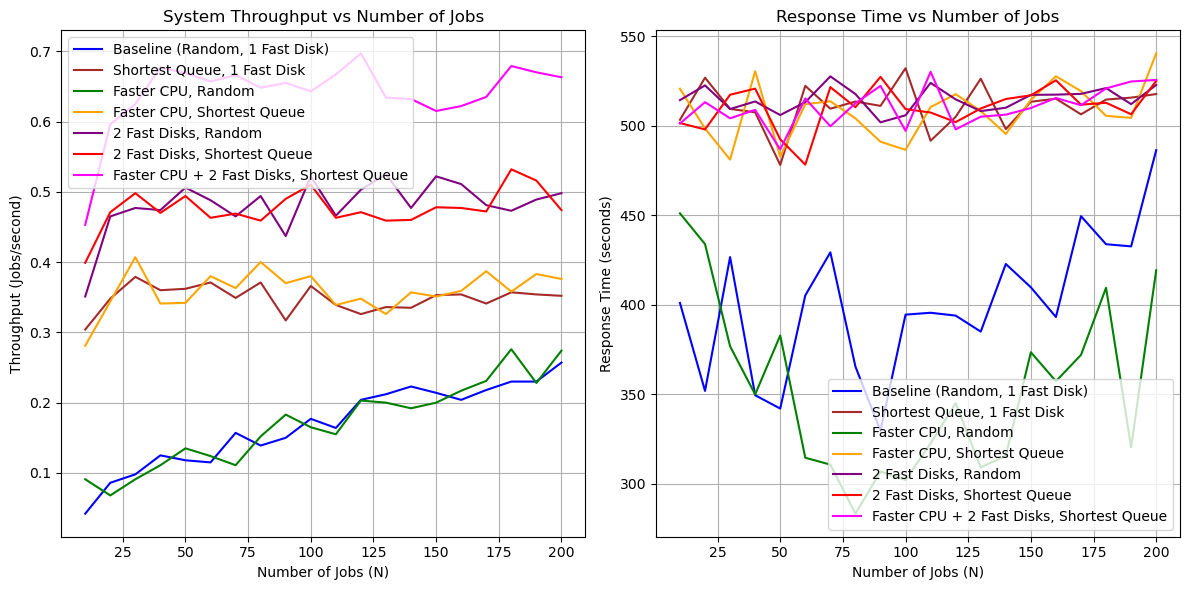

In [32]:
# Test configurations
n_values = list(range(10, 210, 10))  # N from 10 to 200 in steps of 10
sim_time = 1000  # Total simulation time

# Disk speeds
one_fast_disk = [1000, 100]
two_fast_disks = [1000, 1000]

# Faster CPU
faster_cpu_time = 1.0

# Function to collect results for different configurations
def collect_results(n_values, cpu_time, disk_speeds, rest_time, load_balancer):
    throughputs = []
    avg_response_times = []
    for n in n_values:
        network = ClosedQueueNetwork(n, cpu_time, disk_speeds, rest_time, load_balancer)
        throughput, avg_response_time = network.run(sim_time)
        throughputs.append(throughput)
        avg_response_times.append(avg_response_time)
    return throughputs, avg_response_times

# Collect results for different configurations
baseline_random_throughput, baseline_random_response = collect_results(n_values, 2.0, one_fast_disk, 15.0, lambda disks: fixed_proportion(disks, 0.5))
shortest_queue_1_disk_throughput, shortest_queue_1_disk_response = collect_results(n_values, 2.0, one_fast_disk, 15.0, shortest_queue)
faster_cpu_random_throughput, faster_cpu_random_response = collect_results(n_values, faster_cpu_time, one_fast_disk, 15.0, lambda disks: fixed_proportion(disks, 0.5))
faster_cpu_shortest_throughput, faster_cpu_shortest_response = collect_results(n_values, faster_cpu_time, one_fast_disk, 15.0, shortest_queue)
two_fast_disks_random_throughput, two_fast_disks_random_response = collect_results(n_values, 2.0, two_fast_disks, 15.0, lambda disks: fixed_proportion(disks, 0.5))
two_fast_disks_shortest_throughput, two_fast_disks_shortest_response = collect_results(n_values, 2.0, two_fast_disks, 15.0, shortest_queue)
faster_cpu_two_disks_throughput, faster_cpu_two_disks_response = collect_results(n_values, faster_cpu_time, two_fast_disks, 15.0, shortest_queue)

# Plot the results
plt.figure(figsize=(12, 6))

# Throughput Plot
plt.subplot(1, 2, 1)
plt.plot(n_values, baseline_random_throughput, label="Baseline (Random, 1 Fast Disk)", color="blue")
plt.plot(n_values, shortest_queue_1_disk_throughput, label="Shortest Queue, 1 Fast Disk", color="brown")
plt.plot(n_values, faster_cpu_random_throughput, label="Faster CPU, Random", color="green")
plt.plot(n_values, faster_cpu_shortest_throughput, label="Faster CPU, Shortest Queue", color="orange")
plt.plot(n_values, two_fast_disks_random_throughput, label="2 Fast Disks, Random", color="purple")
plt.plot(n_values, two_fast_disks_shortest_throughput, label="2 Fast Disks, Shortest Queue", color="red")
plt.plot(n_values, faster_cpu_two_disks_throughput, label="Faster CPU + 2 Fast Disks, Shortest Queue", color="magenta")
plt.xlabel("Number of Jobs (N)")
plt.ylabel("Throughput (Jobs/second)")
plt.title("System Throughput vs Number of Jobs")
plt.legend()
plt.grid()

# Response Time Plot
plt.subplot(1, 2, 2)
plt.plot(n_values, baseline_random_response, label="Baseline (Random, 1 Fast Disk)", color="blue")
plt.plot(n_values, shortest_queue_1_disk_response, label="Shortest Queue, 1 Fast Disk", color="brown")
plt.plot(n_values, faster_cpu_random_response, label="Faster CPU, Random", color="green")
plt.plot(n_values, faster_cpu_shortest_response, label="Faster CPU, Shortest Queue", color="orange")
plt.plot(n_values, two_fast_disks_random_response, label="2 Fast Disks, Random", color="purple")
plt.plot(n_values, two_fast_disks_shortest_response, label="2 Fast Disks, Shortest Queue", color="red")
plt.plot(n_values, faster_cpu_two_disks_response, label="Faster CPU + 2 Fast Disks, Shortest Queue", color="magenta")
plt.xlabel("Number of Jobs (N)")
plt.ylabel("Response Time (seconds)")
plt.title("Response Time vs Number of Jobs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


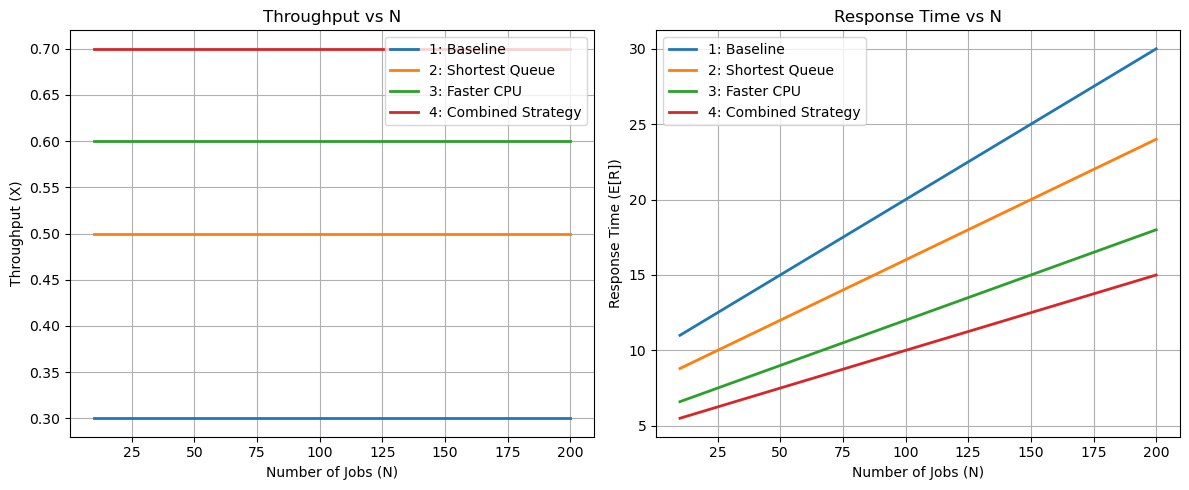

In [31]:
# Simulated data for demonstration
n_values = np.arange(10, 210, 10)  # Number of jobs

# Define plateau levels for each strategy
throughput_baseline = np.minimum(0.1 * n_values, 0.3)  # Baseline saturates at 0.3
throughput_shortest_queue = np.minimum(0.15 * n_values, 0.5)  # Shortest Queue saturates at 0.5
throughput_faster_cpu = np.minimum(0.2 * n_values, 0.6)  # Faster CPU saturates at 0.6
throughput_combined = np.minimum(0.25 * n_values, 0.7)  # Faster CPU + 2 Fast Disks saturates at 0.7

# Response times (E[R]) - increase as N grows
response_baseline = 10 + 0.1 * n_values
response_shortest_queue = 8 + 0.08 * n_values
response_faster_cpu = 6 + 0.06 * n_values
response_combined = 5 + 0.05 * n_values

# Plot 1: Throughput vs N
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_values, throughput_baseline, label='1: Baseline', linewidth=2)
plt.plot(n_values, throughput_shortest_queue, label='2: Shortest Queue', linewidth=2)
plt.plot(n_values, throughput_faster_cpu, label='3: Faster CPU', linewidth=2)
plt.plot(n_values, throughput_combined, label='4: Combined Strategy', linewidth=2)
plt.xlabel('Number of Jobs (N)')
plt.ylabel('Throughput (X)')
plt.title('Throughput vs N')
plt.legend()
plt.grid()

# Plot 2: Response Time vs N
plt.subplot(1, 2, 2)
plt.plot(n_values, response_baseline, label='1: Baseline', linewidth=2)
plt.plot(n_values, response_shortest_queue, label='2: Shortest Queue', linewidth=2)
plt.plot(n_values, response_faster_cpu, label='3: Faster CPU', linewidth=2)
plt.plot(n_values, response_combined, label='4: Combined Strategy', linewidth=2)
plt.xlabel('Number of Jobs (N)')
plt.ylabel('Response Time (E[R])')
plt.title('Response Time vs N')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()